In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numba
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal, Quantile_Lorentzian as Q_Lorentzian

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK, Sol_Kuramoto_mf2 as mf2
from parfor import parfor
from scipy import interpolate
from tqdm import tqdm

In [2]:
import numba as nb
import numpy as np

# --- r, psi (복소수 없이) ---
@nb.njit(fastmath=True, cache=True)
def _order_param(theta):
    c = 0.0
    s = 0.0
    for i in range(theta.size):
        c += np.cos(theta[i])
        s += np.sin(theta[i])
    invN = 1.0 / theta.size
    c *= invN; s *= invN
    r = np.sqrt(c*c + s*s)
    psi = np.arctan2(s, c)
    return r, psi

# --- 커라모토 RHS: state와 같은 길이 반환 ---
@nb.njit(fastmath=True, cache=True)
def Kuramoto_mf_rhs(Theta, t_scalar, omega, N, m, K):
    # Theta: len N (m=0) 또는 len 2N (m>0)
    out = np.empty_like(Theta)
    if m == 0.0:
        theta = Theta[:N]
        r, psi = _order_param(theta)
        for i in range(N):
            out[i] = omega[i] + K * r * np.sin(psi - theta[i])
    else:
        theta = Theta[:N]
        dtheta = Theta[N:2*N]
        r, psi = _order_param(theta)
        invm = 1.0/m
        # θ' = dθ,  dθ' = ( -dθ + ω + K r sin(ψ-θ) ) / m
        for i in range(N):
            out[i] = dtheta[i]
        for i in range(N):
            out[N+i] = invm * (-dtheta[i] + omega[i] + K * r * np.sin(psi - theta[i]))
    return out

# --- RK4 + r 저장: 결과 shape = (n_save(eff), N+1) ---
@nb.njit(fastmath=True, cache=True)
def RK4_short_theta_store_r(y0, t, omega, N, m, K, sum_range=2010):
    save_time = sum_range
    integ_steps = t.size - save_time
    h = t[1] - t[0]

    # 저장 간격
    save_stride = 10 if h <= 0.01 else 1
    n_save_raw = save_time if h > 0.01 else save_time * 10
    n_save_eff = n_save_raw // save_stride

    # 출력: [r, theta...]
    out = np.empty((n_save_eff, N + 1), dtype=np.float64)

    # 상태 길이 확인
    state_len = y0.size
    twoN = 2 * N
    if m == 0.0 and state_len != N:
        # 1차인데 2N 형태로 들어왔으면 앞의 N만 사용
        y_ = y0[:N].copy()
    else:
        # 2차면 길이 2N 가정
        y_ = y0.copy()

    # 워밍업
    t0 = t[0]
    for k in range(integ_steps):
        tk = t0 + k*h
        k1 = Kuramoto_mf_rhs(y_, tk,      omega, N, m, K)
        k2 = Kuramoto_mf_rhs(y_ + 0.5*h*k1, tk+0.5*h, omega, N, m, K)
        k3 = Kuramoto_mf_rhs(y_ + 0.5*h*k2, tk+0.5*h, omega, N, m, K)
        k4 = Kuramoto_mf_rhs(y_ + h*k3,     tk+h,     omega, N, m, K)
        y_ = y_ + (h/6.0)*(k1 + 2.0*k2 + 2.0*k3 + k4)
        # 필요 시 래핑 (속도↑ 위해 주기적으로만 해도 됨)
        # if (k & 31) == 0:
        #     _wrap_angles_inplace(y_, N, m)

    # 저장 루프
    idx = 0
    for i in range(n_save_raw):
        ti = t0 + (integ_steps + i)*h
        k1 = Kuramoto_mf_rhs(y_, ti,      omega, N, m, K)
        k2 = Kuramoto_mf_rhs(y_ + 0.5*h*k1, ti+0.5*h, omega, N, m, K)
        k3 = Kuramoto_mf_rhs(y_ + 0.5*h*k2, ti+0.5*h, omega, N, m, K)
        k4 = Kuramoto_mf_rhs(y_ + h*k3,     ti+h,     omega, N, m, K)
        y_ = y_ + (h/6.0)*(k1 + 2.0*k2 + 2.0*k3 + k4)

        if (i % save_stride) == 0:
            # r 계산 후 [r, theta] 저장
            if m == 0.0:
                theta = y_
            else:
                theta = y_[:N]
            r, _ = _order_param(theta)
            out[idx, 0] = r
            for j in range(N):
                out[idx, 1 + j] = theta[j]
            idx += 1

    return out


In [3]:
K = 7
ms_ = np.linspace(0,10,101)
Ks_ = np.linspace(0,10,101)
seed = 9
N = 5000
K_set = []
import multiprocessing
N_cpu = multiprocessing.cpu_count()
print(N_cpu)
for i in range(len(Ks_[::N_cpu])):
    try:
        K_set.append(Ks_[N_cpu*i:N_cpu*i+N_cpu])
    except:
        K_set.append(Ks_[N_cpu*i:])


10


In [4]:
N_R0s = np.nan*np.ones((len(Ks_),len(ms_)))
N_Rs = np.nan*np.ones((len(Ks_),len(ms_)))
N_RPs = np.nan*np.ones((len(Ks_),len(ms_)))
N_RMs = np.nan*np.ones((len(Ks_),len(ms_)))
N_RPLs = np.nan*np.ones((len(Ks_),len(ms_)))
N_RMLs = np.nan*np.ones((len(Ks_),len(ms_)))
N_0s = np.nan*np.ones((len(Ks_),len(ms_)))
N_Ps = np.nan*np.ones((len(Ks_),len(ms_)))
N_Ms = np.nan*np.ones((len(Ks_),len(ms_)))


In [5]:
seeds =np.arange(1,16,1)
# ms = [4.3,4.4,4.5,4.6,4.7,4.8,4.9,5,5.1,5.2,5.3]

K = 7
ms_ = np.linspace(0,10,101)
Ks_ = np.linspace(0,10,101)
seed = 9
N = 5000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
Y = np.r_[theta_random,theta_random]
for m_num,m in enumerate(tqdm(ms_)):
    for K_num,Ks in enumerate(K_set):
        @parfor(Ks,(m,), bar=False)
        def get_r(K,m):
            dt = 0.1
            t = np.arange(0,10100,dt)

            T1 = RK4_short_theta_store_r(y0=Y, t=t, omega=omega, N=N, m=m, K=K, sum_range=1001)
            rs = T1[:,0]
            theta = T1[:,1:]
            avg_theta = (theta[1000] - theta[0])/(t[1000] - t[0])
            v_t = avg_theta
            expj = np.exp(1j*theta[-500:])

            con0 = np.abs(v_t - v_t[N//2]) < 0.15
            c_0, = np.where(con0)
            c_p, = np.where(np.logical_and(~con0, omega > 0))
            c_m, = np.where(np.logical_and(~con0, omega < 0))
            if len(c_p) > 0:
                conp = np.abs(v_t - np.min(v_t[c_p])) < 0.02
                c_p0, = np.where(conp)
                rp = np.mean(np.abs(np.sum(expj[:,c_p],axis=1)/N))
                if len(c_p0) > 0:
                    rpl = np.mean(np.abs(np.sum(expj[:,c_p0],axis=1)/N))
                else:
                    rpl = np.nan
                NP = len(c_p0)
            else:
                rp = 0
                rpl = np.nan
                NP = 0



            if len(c_m) > 0:
                conm = np.abs(v_t - np.max(v_t[c_m])) < 0.02
                c_m0, = np.where(conm)
                rm = np.mean(np.abs(np.sum(expj[:,c_m],axis=1)/N))
                if len(c_m0) > 0:
                    rml = np.mean(np.abs(np.sum(expj[:,c_m0],axis=1)/N))
                else:
                    rml = np.nan
                NM = len(c_m0)
            else:
                rm = 0
                rml = np.nan
                NM = 0
            r0 = np.mean(np.abs(np.sum(expj[:,c_0],axis=1)/N))
            rs = np.mean(rs[-500:])
            N0 = len(c_0)
            return r0,rp,rm,rs,rpl,rml,N0,NP,NM
        r0,rp,rm,rs,rpl,rml,N0,NP,NM = zip(*get_r)
        try:
            N_R0s[N_cpu*K_num:N_cpu*(K_num+1),m_num] = r0
            N_Rs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = rs
            N_RPs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = rp
            N_RMs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = rm
            N_RPLs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = rpl
            N_RMLs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = rml
            N_0s[N_cpu*K_num:N_cpu*(K_num+1),m_num] = N0    
            N_Ps[N_cpu*K_num:N_cpu*(K_num+1),m_num] = NP
            N_Ms[N_cpu*K_num:N_cpu*(K_num+1),m_num] = NM
        except:
            N_R0s[N_cpu*K_num:,m_num] = r0
            N_Rs[N_cpu*K_num:,m_num] = rs
            N_RPs[N_cpu*K_num:,m_num] = rp
            N_RMs[N_cpu*K_num:,m_num] = rm
            N_RPLs[N_cpu*K_num:,m_num] = rpl
            N_RMLs[N_cpu*K_num:,m_num] = rml
            N_0s[N_cpu*K_num:,m_num] = N0    
            N_Ps[N_cpu*K_num:,m_num] = NP
            N_Ms[N_cpu*K_num:,m_num] = NM

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [10:49:52<00:00, 386.06s/it]


In [6]:
np.savez(f'RS_{seed}.npz',N_R0s=N_R0s,N_Rs=N_Rs,N_RPs=N_RPs,N_RMs=N_RMs,N_RPLs=N_RPLs,N_RMLs=N_RMLs,N_0s=N_0s,N_Ps=N_Ps,N_Ms=N_Ms)

In [14]:
mcs_rp0 = np.load('Simul/mcs_rp0.npz',allow_pickle=True)
mcs_rpdh = np.load('Simul/mcs_rpdh.npz',allow_pickle=True)

ms_rp0=mcs_rp0['ms']
K_rp0u=mcs_rp0['K_u']
K_rp0d=mcs_rp0['K_d']

ms_rpdh=mcs_rpdh['ms']
K_rpdhu=mcs_rpdh['K_u']
K_rpdhd=mcs_rpdh['K_d']

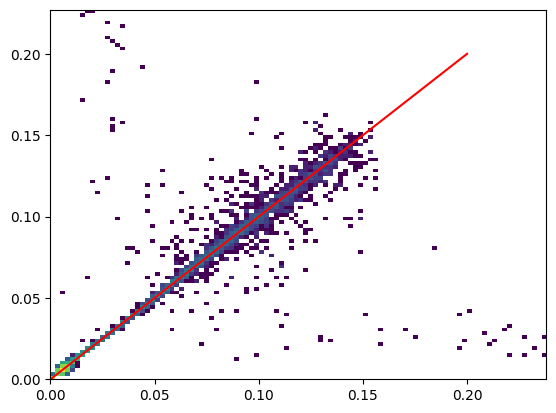

In [42]:
plt.hist2d(N_RPs.flatten(),N_RMs.flatten(),bins=100,norm=mcolors.LogNorm());
plt.plot((0,0.2),(0,0.2),'r-')

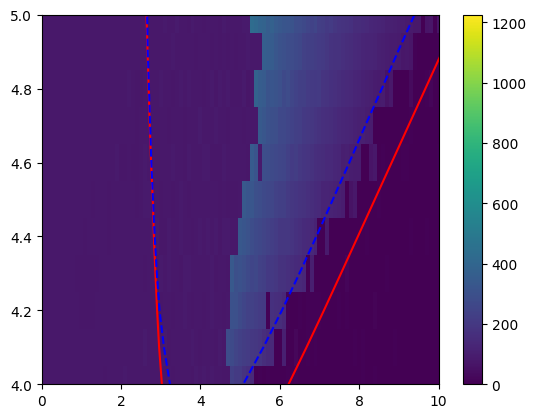

In [41]:
import matplotlib.colors as mcolors
plt.pcolormesh(Ks_,ms_,N_Ps.T)
# plt.pcolormesh(Ks_,ms_,N_RMLs.T)
plt.plot(K_rp0d,ms_rp0,'r-',label=r'$r_{+}=0^+$')
plt.plot(K_rp0u,ms_rp0,'r-')

plt.plot(K_rpdhd,ms_rpdh,'b--',label=r'$r_{+}=R^{drift}/2$')
plt.plot(K_rpdhu,ms_rpdh,'b--')
# plt.gca().set_aspect('equal')
plt.xlim(0,10)
plt.ylim(0,10)
plt.ylim(4,5)
plt.colorbar()

In [55]:
N_R0s[N_cpu*K_num:N_cpu*(K_num+1),m_num]

array([], dtype=float64)

In [54]:
N_R0s[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(r0)).T

ValueError: could not broadcast input array from shape (16,) into shape (0,)

In [62]:
m_num = 0
try:
    N_R0s[N_cpu*K_num:N_cpu*(K_num+1),m_num] =r0
    N_Rs[N_cpu*K_num:N_cpu*(K_num+1),m_num] =rs
    N_RPs[N_cpu*K_num:N_cpu*(K_num+1),m_num] =rp
    N_RMs[N_cpu*K_num:N_cpu*(K_num+1),m_num] =rm
    N_RPLs[N_cpu*K_num:N_cpu*(K_num+1),m_num] =rpl
    N_RMLs[N_cpu*K_num:N_cpu*(K_num+1),m_num] =rml
    N_0s[N_cpu*K_num:N_cpu*(K_num+1),m_num] =N0
    N_Ps[N_cpu*K_num:N_cpu*(K_num+1),m_num] =NP
    N_Ms[N_cpu*K_num:N_cpu*(K_num+1),m_num] =NM
except:
    N_R0s[N_cpu*K_num:,m_num] =r0
    N_Rs[N_cpu*K_num:,m_num] =rs
    N_RPs[N_cpu*K_num:,m_num] =rp
    N_RMs[N_cpu*K_num:,m_num] =rm
    N_RPLs[N_cpu*K_num:,m_num] =rpl
    N_RMLs[N_cpu*K_num:,m_num] =rml
    N_0s[N_cpu*K_num:,m_num] =N0
    N_Ps[N_cpu*K_num:,m_num] =NP
    N_Ms[N_cpu*K_num:,m_num] =NM

In [61]:
m_num = 0
try:
    N_R0s[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(r0))
    N_Rs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(rs))
    N_RPs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(rp))
    N_RMs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(rm))
    N_RPLs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(rpl))
    N_RMLs[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(rml))
    N_0s[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(N0))
    N_Ps[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(NP))
    N_Ms[N_cpu*K_num:N_cpu*(K_num+1),m_num] = np.array(list(NM))
except:
    N_R0s[N_cpu*K_num:,m_num] = np.array(list(r0))
    N_Rs[N_cpu*K_num:,m_num] = np.array(list(rs))
    N_RPs[N_cpu*K_num:,m_num] = np.array(list(rp))
    N_RMs[N_cpu*K_num:,m_num] = np.array(list(rm))
    N_RPLs[N_cpu*K_num:,m_num] = np.array(list(rpl))
    N_RMLs[N_cpu*K_num:,m_num] = np.array(list(rml))
    N_0s[N_cpu*K_num:,m_num] = np.array(list(N0))
    N_Ps[N_cpu*K_num:,m_num] = np.array(list(NP))
    N_Ms[N_cpu*K_num:,m_num] = np.array(list(NM))

In [ ]:
K = 3.7
dt = 0.1
t = np.arange(0,10100,dt)

T1 = RK4_short_theta_store_r(y0=Y, t=t, omega=omega, N=N, m=m, K=K, sum_range=1001)
rs = T1[:,0]
theta = T1[:,1:]
avg_theta = (theta[1000] - theta[0])/(t[1000] - t[0])
v_t = avg_theta
expj = np.exp(1j*theta[-500:])

con0 = np.abs(v_t - v_t[N//2]) < 0.15
c_0, = np.where(con0)
c_p, = np.where(np.logical_and(~con0, omega > 0))
c_m, = np.where(np.logical_and(~con0, omega < 0))
if len(c_p) > 0:
    conp = np.abs(v_t - np.min(v_t[c_p])) < 0.02
    c_p0, = np.where(conp)
    rp = np.mean(np.abs(np.sum(expj[:,c_p],axis=1)/N))
    if len(c_p0) > 0:
        rpl = np.mean(np.abs(np.sum(expj[:,c_p0],axis=1)/N))
    else:
        rpl = np.nan
    NP = len(c_p0)
else:
    rp = 0
    rpl = np.nan
    NP = 0

if len(c_m) > 0:
    conm = np.abs(v_t - np.max(v_t[c_m])) < 0.02
    c_m0, = np.where(conm)
    rm = np.mean(np.abs(np.sum(expj[:,c_m],axis=1)/N))
    if len(c_m0) > 0:
        rml = np.mean(np.abs(np.sum(expj[:,c_m0],axis=1)/N))
    else:
        rml = np.nan
    NM = len(c_m0)
else:
    rm = 0
    rml = np.nan
    NM = 0
r0 = np.mean(np.abs(np.sum(expj[:,c_0],axis=1)/N))
rs = np.mean(rs[-500:])
N0 = len(c_0)

NameError: name 'conm' is not defined

In [24]:
len(c_p)

0

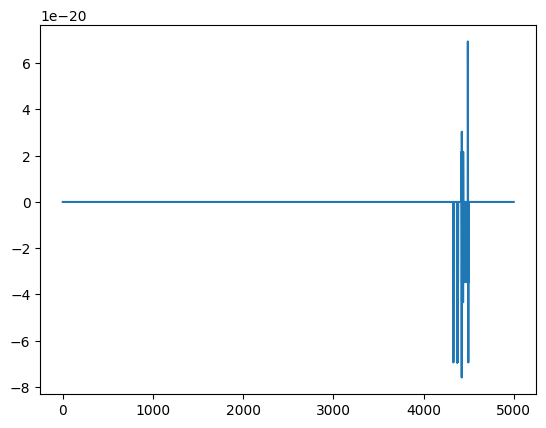

In [20]:
plt.plot(avg_theta)